In [1]:
import os
import importlib
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

from utils.data import DataTree
import snapfish2 as sf
importlib.reload(sf)
sf.MulFish.default_cols.extend(["Replicate", "FOV"])

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
out_dire = "../123ACElog/013125"

## Loop calling on merged data from two replicates

In [4]:
dtree = DataTree("../data")
dfs = []
for k in ["rep1", "rep2"]:
    data_name = dtree["takei_nature_2021","25Kb",k]
    df = sf.MulFish(data_name).data
    df["Trace_ID"] = k + "_" + df["Trace_ID"]  # Ensure Trace_ID is unique
    df["Replicate"] = k
    df["X"] *= 103; df["Y"] *= 103; df["Z"] *= 250  # Convert to nm
    dfs.append(df)
mfr = sf.MulFish(pd.concat(dfs, ignore_index=True))
del df, dfs

In [11]:
slc1 = sf.loop.LoopCaller(mfr.data, "carr", cut_lo=1e5, cut_up=1e6, gap=50e3)
loop_result_sf1_path = os.path.join(out_dire, "loop_result_sf1.csv")
if not os.path.exists(loop_result_sf1_path):
    loop_result_sf1 = slc1.loops_from_all_chr(sf.loop.TwoSampleT)
    loop_result_sf1.to_csv(loop_result_sf1_path, index=False)
else:
    loop_result_sf1 = pd.read_csv(loop_result_sf1_path)
loop_result_sf2_path = os.path.join(out_dire, "loop_result_sf2.csv")
if not os.path.exists(loop_result_sf2_path):
    loop_result_sf2 = slc1.loops_from_all_chr(sf.loop.AxisWiseF)
    loop_result_sf2.to_csv(loop_result_sf2_path, index=False)
else:
    loop_result_sf2 = pd.read_csv(loop_result_sf2_path)

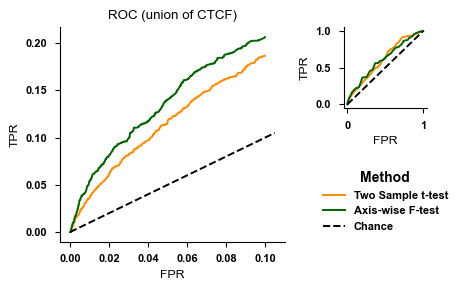

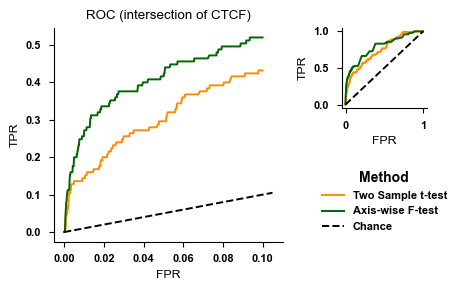

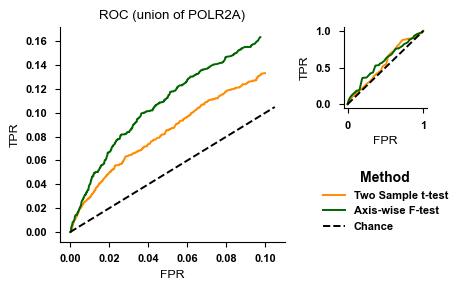

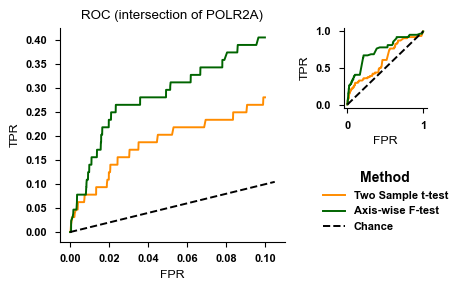

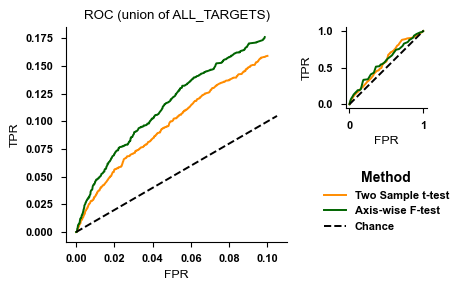

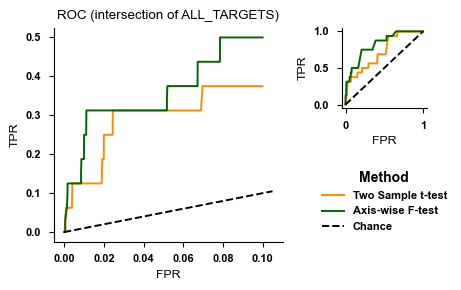

In [12]:
from utils.utils import to_loop_roc_df
chiapet_dire = "../data/chiapet_mesc"
fpath = "chiapet_all_replicates_{}_{}.csv"
target = ["ctcf", "polr2a", "all_targets"]
kind = ["union", "intersection"]

r1, r2 = loop_result_sf1, loop_result_sf2

for t in target:
    for k in kind:
        true_path = os.path.join(chiapet_dire, fpath.format(t, k))
        rr = to_loop_roc_df(r1, r2, true_path)
        df1 = pd.DataFrame(roc_curve(rr["loop"], rr["thresh1"])[:-1]).T
        df1["Method"] = "Two Sample t-test"
        df2 = pd.DataFrame(roc_curve(rr["loop"], rr["thresh2"])[:-1]).T
        df2["Method"] = "Axis-wise F-test"
        df = pd.concat([df1, df2], ignore_index=True)
        df.columns = ["FPR", "TPR", "Method"]
        fig = plt.figure(figsize=(4.5, 3))
        ax = fig.add_subplot(1, 3, (1,2))
        sns.lineplot(
            df[df["FPR"] <= .1], 
            x="FPR", y="TPR", hue="Method", 
            palette=["darkorange", "darkgreen"], 
            ax=ax
        )
        upper = min(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([0, upper], [0, upper], "--k", label="Chance")
        ax.get_legend().remove()
        handles, labels = ax.get_legend_handles_labels()
        ax.set(title = f"ROC ({k} of {t.upper()})")
        ax = fig.add_subplot(2, 3, 3)
        sns.lineplot(
            df, 
            x="FPR", y="TPR", hue="Method", 
            palette=["darkorange", "darkgreen"], 
            ax=ax
        )
        ax.plot([0, 1], [0, 1], "--k")
        ax.get_legend().remove()
        warnings.filterwarnings("ignore", ".*layout.*")
        plt.tight_layout()

        ax_legend = fig.add_subplot(2, 3, 6)
        ax_legend.axis('off')  # Turn off axis for legend
        ax_legend.legend(handles, labels, loc='center', title="Method")

        fig.savefig(os.path.join(out_dire, f"full_{t}_{k}.pdf"), bbox_inches="tight") 

In [13]:
fdrs_tmp = 10.**(-np.arange(1, 11, 1))
fdrs = []
path1 = os.path.join(out_dire, "loop_result_sf1_fdr_{}.csv")
path2 = os.path.join(out_dire, "loop_result_sf2_fdr_{}.csv")
for fdr in fdrs_tmp:
    if not os.path.exists(path1.format(fdr)) or \
        not os.path.exists(path2.format(fdr)):
        fdrs.append(fdr)
fdrs = np.array(fdrs)

if len(fdrs) > 0:
    dict1, dict2 = {f:[] for f in fdrs}, {f:[] for f in fdrs}

    for chr_id in pd.unique(slc1._data.Chrom):
        chr_df = slc1._data[slc1._data["Chrom"]==chr_id]
        chr_df_pivoted, arr = sf.utils.load.to_very_wide(chr_df)
        d1d = chr_df_pivoted.index.values
        res1 = slc1.loops_from_single_chr(chr_id, sf.loop.TwoSampleT)
        res2 = slc1.loops_from_single_chr(chr_id, sf.loop.AxisWiseF)

        for fdr in fdrs:
            slc1._fdr_to_summit(res1, fdr, d1d, arr, sf.loop.TwoSampleT)
            dict1[fdr].append(slc1.to_bedpe(res1, chr_id))
            
            slc1._fdr_to_summit(res2, fdr, d1d, arr, sf.loop.AxisWiseF)
            dict2[fdr].append(slc1.to_bedpe(res2, chr_id))

    dict1 = {k:pd.concat(v, ignore_index=True) for k, v in dict1.items()}
    dict2 = {k:pd.concat(v, ignore_index=True) for k, v in dict2.items()}

    for fdr, df in dict1.items():
        df.to_csv(path1.format(fdr), index=False)
    for fdr, df in dict2.items():
        df.to_csv(path2.format(fdr), index=False)

AttributeError: 'LoopCaller' object has no attribute '_fdr_to_summit'

In [16]:
noised = sf.MulFish(mfr.data.copy())
np.random.seed(100)
noised.data["Z"] += stats.norm.rvs(size=(len(mfr.data["Z"])), scale=50)
slc2 = sf.loop.LoopCaller(noised.data, "carr", cut_lo=1e5, cut_up=1e6, gap=50e3)
loop_result_sf1_noised_path = os.path.join(out_dire, "loop_result_sf1_noised.csv")
if not os.path.exists(loop_result_sf1_noised_path):
    loop_result_sf1_noised = slc2.loops_from_all_chr(sf.loop.TwoSampleT)
    loop_result_sf1_noised.to_csv(loop_result_sf1_noised_path, index=False)
else:
    loop_result_sf1_noised = pd.read_csv(loop_result_sf1_noised_path)
loop_result_sf2_noised_path = os.path.join(out_dire, "loop_result_sf2_noised.csv")
if not os.path.exists(loop_result_sf2_noised_path):
    loop_result_sf2_noised = slc2.loops_from_all_chr(sf.loop.AxisWiseF)
    loop_result_sf2_noised.to_csv(loop_result_sf2_noised_path, index=False)
else:
    loop_result_sf2_noised = pd.read_csv(loop_result_sf2_noised_path)

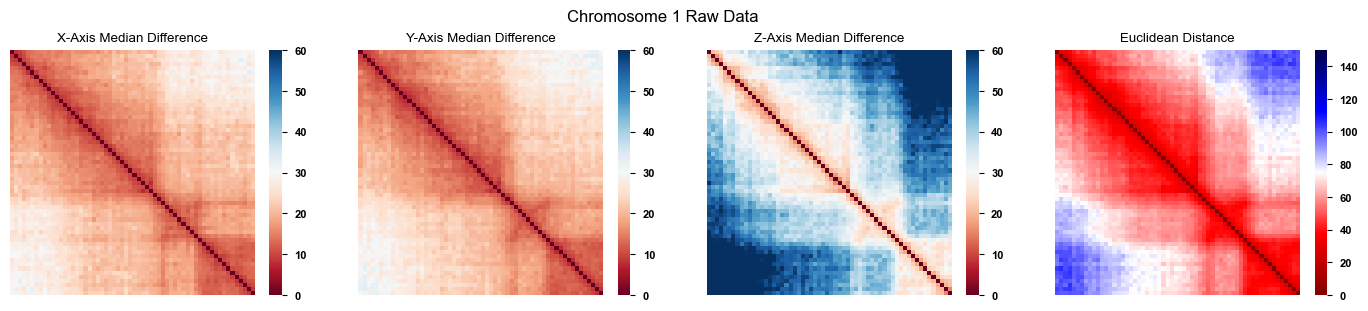

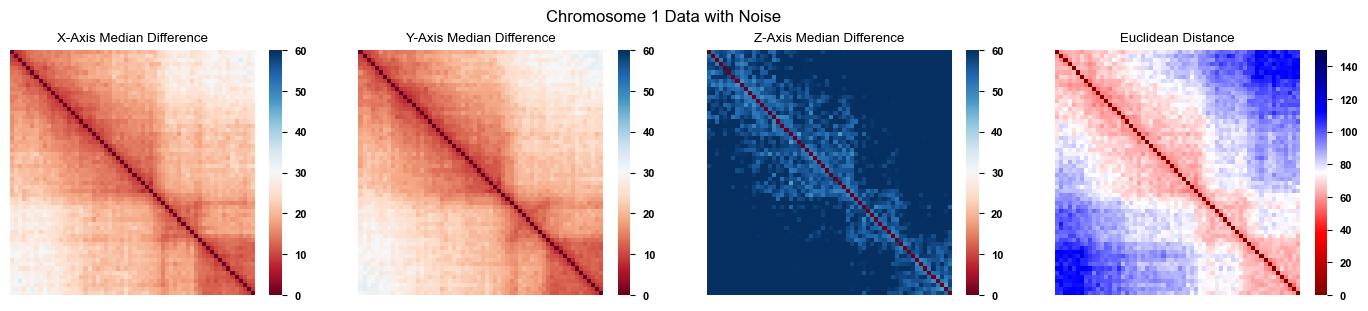

In [17]:
chr_id = "chr1"
arr = sf.utils.load.to_very_wide(mfr[chr_id])[1]
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
axes_lab = [f"{t}-Axis Median Difference" for t in ["X", "Y", "Z"]]
for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=0)):
    sf.pl.pairwise_heatmap(mat, ax=axes[i], title=axes_lab[i], 
                                    cmap="RdBu", vmin=0, vmax=60)
dist_mat = np.nanmedian(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)
sf.pl.pairwise_heatmap(dist_mat, vmax=150, ax=axes[3],
                                title="Euclidean Distance")
fig.suptitle(f"Chromosome {chr_id[3:]} Raw Data")
fig.savefig(os.path.join(out_dire, "median_hm_raw.pdf"), bbox_inches="tight")

arr = sf.utils.load.to_very_wide(noised[chr_id])[1]
fig, axes = plt.subplots(1, 4, figsize=(14, 3))
axes_lab = [f"{t}-Axis Median Difference" for t in ["X", "Y", "Z"]]
for i, mat in enumerate(np.nanmedian(np.abs(arr), axis=0)):
    sf.pl.pairwise_heatmap(mat, ax=axes[i], title=axes_lab[i], 
                                    cmap="RdBu", vmin=0, vmax=60)
dist_mat = np.nanmedian(np.sqrt(np.sum(np.square(arr), axis=1)), axis=0)
sf.pl.pairwise_heatmap(dist_mat, vmax=150, ax=axes[3],
                                title="Euclidean Distance")
fig.suptitle(f"Chromosome {chr_id[3:]} Data with Noise")
fig.savefig(os.path.join(out_dire, "median_hm_noi.pdf"), bbox_inches="tight")

In [18]:
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
df1 = pd.merge(loop_result_sf1, loop_result_sf1_noised, on=cols, how="inner")
df1 = df1.dropna(subset=["fdr_x", "fdr_y"])
df2 = pd.merge(loop_result_sf2, loop_result_sf2_noised, on=cols, how="inner")
df2 = df2.dropna(subset=["fdr_x", "fdr_y"])
corr_df = []
for chr_id in pd.unique(df1["c1"]):
    df = df1[df1["c1"]==chr_id]
    # Remove small p-values that likely cause numerical instability
    df = df[(df["pval_x"] > 1e-10)&(df["pval_y"] > 1e-10)]
    r = stats.pearsonr(df["pval_x"], df["pval_y"])[0]
    corr_df.append([r, "Two Sample t-test", len(df), chr_id])
    
    df = df2[df2["c1"]==chr_id]
    # Remove small p-values that likely cause numerical instability
    df = df[(df["pval_x"] > 1e-10)&(df["pval_y"] > 1e-10)]
    r = stats.pearsonr(df["pval_x"], df["pval_y"])[0]
    corr_df.append([r, "Axis-wise F-test", len(df), chr_id])
corr_df = pd.DataFrame(corr_df, columns=["Pearson", "Method", "N", "Chr"])

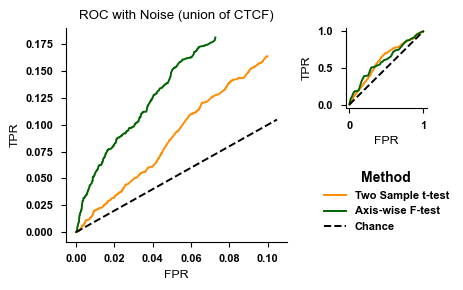

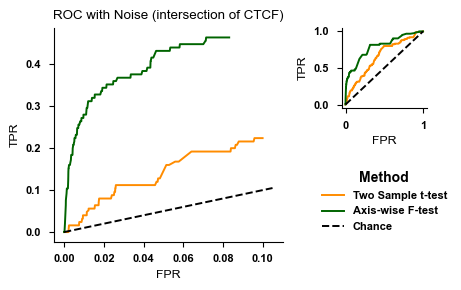

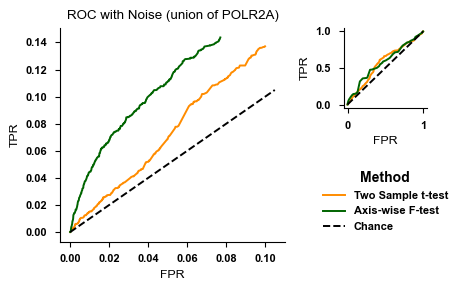

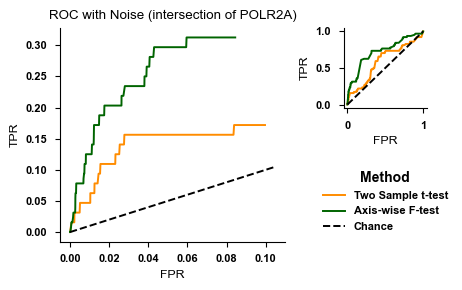

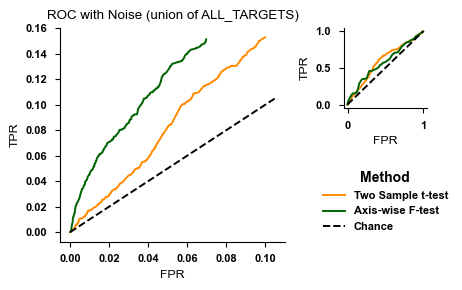

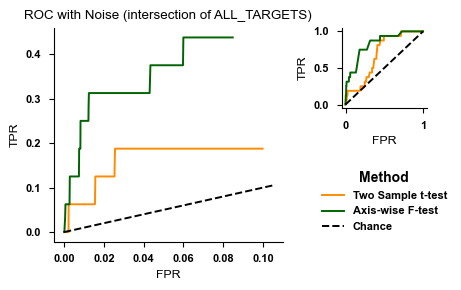

In [19]:
from utils.utils import to_loop_roc_df
chiapet_dire = "../data/chiapet_mesc"
fpath = "chiapet_all_replicates_{}_{}.csv"
target = ["ctcf", "polr2a", "all_targets"]
kind = ["union", "intersection"]

r1, r2 = loop_result_sf1_noised, loop_result_sf2_noised

for t in target:
    for k in kind:
        true_path = os.path.join(chiapet_dire, fpath.format(t, k))
        rr = to_loop_roc_df(r1, r2, true_path)
        df1 = pd.DataFrame(roc_curve(rr["loop"], rr["thresh1"])[:-1]).T
        df1["Method"] = "Two Sample t-test"
        df2 = pd.DataFrame(roc_curve(rr["loop"], rr["thresh2"])[:-1]).T
        df2["Method"] = "Axis-wise F-test"
        df = pd.concat([df1, df2], ignore_index=True)
        df.columns = ["FPR", "TPR", "Method"]
        fig = plt.figure(figsize=(4.5, 3))
        ax = fig.add_subplot(1, 3, (1,2))
        sns.lineplot(
            df[df["FPR"] <= .1], 
            x="FPR", y="TPR", hue="Method", 
            palette=["darkorange", "darkgreen"], 
            ax=ax
        )
        upper = min(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([0, upper], [0, upper], "--k", label="Chance")
        ax.get_legend().remove()
        handles, labels = ax.get_legend_handles_labels()
        ax.set(title = f"ROC with Noise ({k} of {t.upper()})")
        ax = fig.add_subplot(2, 3, 3)
        sns.lineplot(
            df, 
            x="FPR", y="TPR", hue="Method", 
            palette=["darkorange", "darkgreen"], 
            ax=ax
        )
        ax.plot([0, 1], [0, 1], "--k")
        ax.get_legend().remove()
        warnings.filterwarnings("ignore", ".*layout.*")
        plt.tight_layout()

        ax_legend = fig.add_subplot(2, 3, 6)
        ax_legend.axis('off')  # Turn off axis for legend
        ax_legend.legend(handles, labels, loc='center', title="Method")

        fig.savefig(os.path.join(out_dire, f"full_{t}_{k}_noised.pdf"), bbox_inches="tight") 

## Using the noise-free as the ground truth

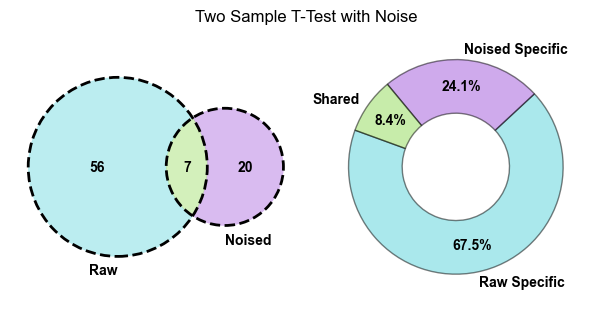

In [20]:
from matplotlib_venn import venn2, venn2_circles
from snapfish2.utils.func import loop_overlap

colors = sns.color_palette("hls", 4)[1:]
colors = [colors[1], colors[2], colors[0]]

overlap1 = np.sum(loop_overlap(
    loop_result_sf1_noised[loop_result_sf1_noised.summit],
    loop_result_sf1[loop_result_sf1.summit], offset=25e3
).overlapped.values == 3)
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
subsets = (
    np.sum(loop_result_sf1.summit) - overlap1,
    np.sum(loop_result_sf1_noised.summit) - overlap1,
    overlap1
)
v = venn2(subsets=subsets, set_labels=("Raw", "Noised"), ax=axes[0])
v.get_patch_by_id("10").set_color(colors[0])
v.get_patch_by_id("01").set_color(colors[1])
v.get_patch_by_id("11").set_color(colors[2])
fontsize = v.get_label_by_id("01").get_fontsize()
for text in v.set_labels:
    text.set_fontsize(fontsize)
venn2_circles(subsets=subsets, linestyle="dashed", ax=axes[0])

axes[1].pie(
    subsets, labels=["Raw Specific", "Noised Specific", "Shared"],
    autopct="%1.1f%%", startangle=160, 
    labeldistance=1.1, pctdistance=.75,
    wedgeprops=dict(width=.5, edgecolor="k", linewidth=1, alpha=.5),
    textprops=dict(color="k", fontsize=fontsize),
    colors=colors
)
fig.suptitle("Two Sample T-Test with Noise")
fig.savefig(os.path.join(out_dire, "venn_noised_sf1.pdf"), bbox_inches="tight")

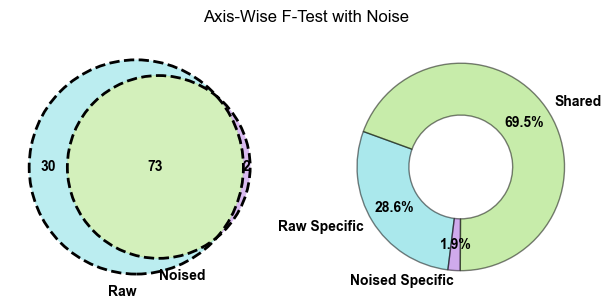

In [21]:
overlap2 = np.sum(loop_overlap(
    loop_result_sf2_noised[loop_result_sf2_noised.summit],
    loop_result_sf2[loop_result_sf2.summit], offset=25e3
).overlapped.values == 3)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
subsets = (
    np.sum(loop_result_sf2.summit) - overlap2,
    np.sum(loop_result_sf2_noised.summit) - overlap2,
    overlap2
)
v = venn2(subsets=subsets, set_labels=("Raw", "Noised"), ax=axes[0])
v.get_patch_by_id("10").set_color(colors[0])
v.get_patch_by_id("01").set_color(colors[1])
v.get_patch_by_id("11").set_color(colors[2])
fontsize = v.get_label_by_id("01").get_fontsize()
for text in v.set_labels:
    text.set_fontsize(fontsize)
venn2_circles(subsets=subsets, linestyle="dashed", ax=axes[0])

axes[1].pie(
    subsets, labels=["Raw Specific", "Noised Specific", "Shared"],
    autopct="%1.1f%%", startangle=160, 
    labeldistance=1.1, pctdistance=.75,
    wedgeprops=dict(width=.5, edgecolor="k", linewidth=1, alpha=.5),
    textprops=dict(color="k", fontsize=fontsize),
    colors=colors
)
fig.suptitle("Axis-Wise F-Test with Noise")
fig.savefig(os.path.join(out_dire, "venn_noised_sf2.pdf"), bbox_inches="tight")

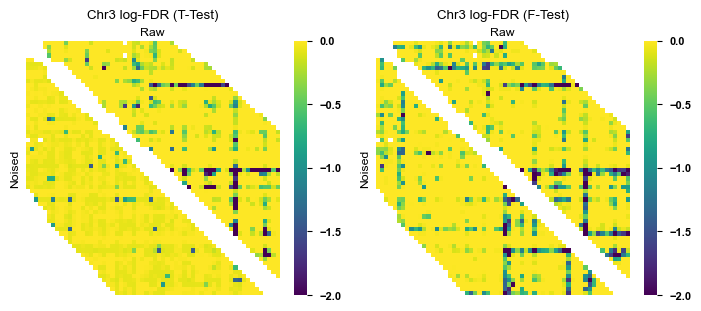

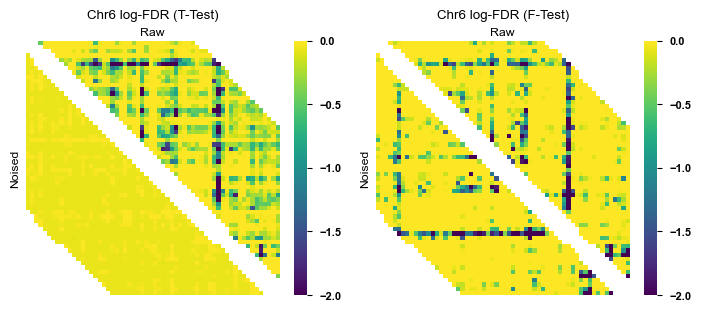

In [22]:
for chr_id in ["chr3", "chr6"]:
    res1 = slc1.loops_from_single_chr(chr_id, sf.loop.TwoSampleT)
    res1_noised = slc2.loops_from_single_chr(chr_id, sf.loop.TwoSampleT)
    res2 = slc1.loops_from_single_chr(chr_id, sf.loop.AxisWiseF)
    res2_noised = slc2.loops_from_single_chr(chr_id, sf.loop.AxisWiseF)

    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    cbar_ticks = [-2, -1.5, -1, -.5, 0]
    sf.pl.pairwise_heatmap(
        X1=np.log(res1["fdr"]), X2=np.log(res1_noised["fdr"]),
        vmax=0, vmin=-2, ax=axes[0], x="Raw", y="Noised",
        title=f"{chr_id.title()} log-FDR (T-Test)",
        cmap="viridis",
        cbar_kws={'ticks': cbar_ticks},
    )
    sf.pl.pairwise_heatmap(
        X1=np.log(res2["fdr"]), X2=np.log(res2_noised["fdr"]),
        vmax=0, vmin=-2, ax=axes[1], x="Raw", y="Noised",
        title=f"{chr_id.title()} log-FDR (F-Test)",
        cmap="viridis",
        cbar_kws={'ticks': cbar_ticks}
    )
    fig.savefig(os.path.join(out_dire, f"{chr_id}_fdr_noised.pdf"), 
                bbox_inches="tight")

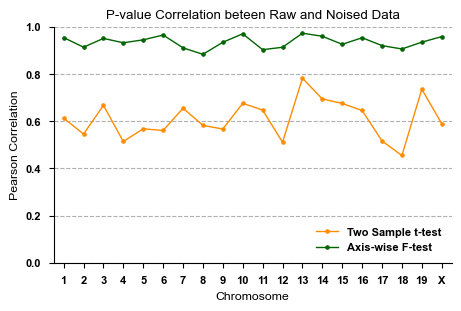

In [23]:
fig, ax = plt.subplots(figsize=(4.5, 3))
sns.pointplot(data=corr_df, x="Chr", y="Pearson", hue="Method", linewidth=1, 
              palette={"Two Sample t-test":"darkorange", 
                       "Axis-wise F-test":"darkgreen"}, ax=ax)
ax.set(ylim=(0, 1), title="P-value Correlation beteen Raw and Noised Data")
ax.set(xlabel="Chromosome", ylabel="Pearson Correlation")
xticklabels = [t[3:] for t in pd.unique(corr_df["Chr"])]
ax.set(xticks=ax.get_xticks(), xticklabels=xticklabels)
ax.legend(loc="lower right")
ax.grid(True, axis="y", linestyle="--")
fig.savefig(os.path.join(out_dire, "pval_corr.pdf"), bbox_inches="tight")

## FitHiC2 and HiCCUPS

In [417]:
fithic2_path = "../data/bonev_2017/FitHiC_outputs"
f = "fithic_chrALL.spline_pass2.res10000.significances_PEAKS.txt.gz"
fithic2 = pd.read_csv(os.path.join(fithic2_path, f), sep="\t")
fithic2.rename(columns={"chr1":"c2", "chr2":"c1"}, inplace=True)
fithic2["c1"] = "chr" + fithic2["c1"].astype("str")
fithic2["c2"] = "chr" + fithic2["c2"].astype("str")
fithic2["s1"] = (fithic2["fragmentMid2"] - 5e3).astype("int64")
fithic2["e1"] = (fithic2["fragmentMid2"] + 5e3).astype("int64")
fithic2["s2"] = (fithic2["fragmentMid1"] - 5e3).astype("int64")
fithic2["e2"] = (fithic2["fragmentMid1"] + 5e3).astype("int64")
cols = ["c1", "s1", "e1", "c2", "s2", "e2"]
fithic2 = fithic2[cols + fithic2.columns.drop(cols).tolist()]

from snapfish2.loop.func import all_possible_pairs
d1df = mfr.data[["Chrom", "Chrom_Start", "Chrom_End"]].drop_duplicates()
pairs = all_possible_pairs(d1df)
fithic2_df = loop_overlap(pairs, fithic2, offset=0)
fithic2_df["loop"] = fithic2_df["overlapped"] == 3

In [460]:
fithic2_merged = "../data/bonev_2017/FitHiC_filtered"
merged_fname = "merged_{}.spline_pass2.res10000.fdr{}.gz"

fdr = .0001
merged_fithic_loops = []
for i in range(1, 20):
    path = os.path.join(fithic2_merged, merged_fname.format(f"chr{i}", fdr))
    df = pd.read_csv(path, sep="\t").rename(columns={
        "chr1":"c1", "chr2":"c2", 
        "bin1_low":"s1", "bin1_high":"e1",
        "bin2_low":"s2", "bin2_high":"e2"
    })[["c1", "s1", "e1", "c2", "s2", "e2", "CC", "p", "fdr"]]
    d1df = mfr[f"chr{i}"][["Chrom", "Chrom_Start", "Chrom_End"]].drop_duplicates()
    pairs = all_possible_pairs(d1df)
    df = loop_overlap(pairs, df, offset=0)
    df["loop"] = df["overlapped"] == 3
    merged_fithic_loops.append(df)
merged_fithic_loops = pd.concat(merged_fithic_loops, ignore_index=True)
merged_fithic_loops[merged_fithic_loops.loop]

,c1,s1,e1,c2,s2,e2,overlapped,loop


[Text(0.5, 1.0, 'FitHiC Loops by FDR')]

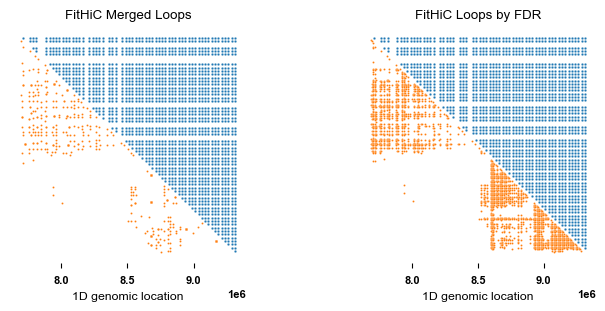

In [473]:
i = 3
fdr = .001
path = os.path.join(fithic2_merged, merged_fname.format(f"chr{i}", fdr))
df = pd.read_csv(path, sep="\t").rename(columns={
        "chr1":"c1", "chr2":"c2", 
        "bin1_low":"s1", "bin1_high":"e1",
        "bin2_low":"s2", "bin2_high":"e2"
    })[["c1", "s1", "e1", "c2", "s2", "e2", "CC", "p", "fdr"]]
d1df = mfr[f"chr{i}"][["Chrom", "Chrom_Start", "Chrom_End"]].drop_duplicates()
pairs = all_possible_pairs(d1df)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
snapfish2.plot.compare_loops(pairs, df, "", "", ax=axes[0])
axes[0].set(title="FitHiC Merged Loops")

fdr_fname = "fithic_{}.spline_pass2.res10000.significances.txt.gz"
path = os.path.join(fithic2_merged, fdr_fname.format(f"chr{i}"))
df = pd.read_csv(path, sep="\t")
df.rename(columns={"chr1":"c2", "chr2":"c1"}, inplace=True)
df["c1"] = "chr" + df["c1"].astype("str")
df["c2"] = "chr" + df["c2"].astype("str")
df["s1"] = (df["fragmentMid2"] - 5e3).astype("int64")
df["e1"] = (df["fragmentMid2"] + 5e3).astype("int64")
df["s2"] = (df["fragmentMid1"] - 5e3).astype("int64")
df["e2"] = (df["fragmentMid1"] + 5e3).astype("int64")
df = df[df["q-value"] < fdr]

snapfish2.plot.compare_loops(pairs, df, "", "", ax=axes[1])
axes[1].set(title="FitHiC Loops by FDR")

In [433]:
old_dire = "../../SnapFISH-IMPUTE/figures/data_mESC_seqFISH"
old_fithic2 = pd.read_csv(os.path.join(old_dire, "fithic2_loops.txt"), sep="\t")
old_fithic2.rename(columns={
    "chr1":"c2", "chr2":"c1", "x1":"s1", "x2":"e1", "y1":"s2", "y2":"e2",
}, inplace=True)
old_fithic2["c1"] = "chr" + old_fithic2["c1"].astype("str")
old_fithic2["c2"] = "chr" + old_fithic2["c2"].astype("str")
old_fithic2["loop"] = True

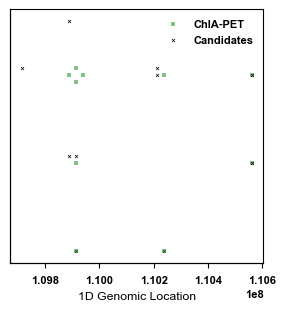

In [474]:
chr_id = "chr2"
true_df = pd.read_csv(os.path.join(
    chiapet_dire, fpath.format("ctcf", "intersection")
), sep="\t")
# true_df = old_fithic2
df1 = true_df[true_df.loop]
df1 = df1[df1["c1"]==chr_id]
df2 = loop_result_sf2[loop_result_sf2.fdr < 1e-2]
df2 = df2[df2["c1"]==chr_id]
eval_func = np.mean
map1, map2 = "ChIA-PET", "Candidates"
ax = None

df1, df2 = df1.copy(), df2.copy()
df1["val1"] = eval_func(df1[["s1", "e1"]], axis=1)
df1["val2"] = eval_func(df1[["s2", "e2"]], axis=1)
df2["val1"] = eval_func(df2[["s1", "e1"]], axis=1)
df2["val2"] = eval_func(df2[["s2", "e2"]], axis=1)

if ax is None:
    fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(df1, x="val2", y="val1", s=5, color="green",
                marker="s", alpha=0.5, ax=ax, label=map1)
sns.scatterplot(df2, x="val1", y="val2", s=5, linewidths=.5,
                ax=ax, color="k", marker="x", label=map2)
sns.scatterplot(df1, x="val1", y="val2", s=5, color="green",
                marker="s", alpha=0.5, ax=ax)
sns.scatterplot(df2, x="val2", y="val1", s=5, linewidths=.5,
                ax=ax, color="k", marker="x")
ax.set(xlabel="1D Genomic Location", ylabel="", yticks=[])
ax.invert_yaxis()
ax2 = ax.twiny()
ax2.set(xlabel="", xticks=[], ylabel="")
ax.set_box_aspect(1)

ax.spines[["top", "right"]].set_visible(True)
ax.legend(loc="best")

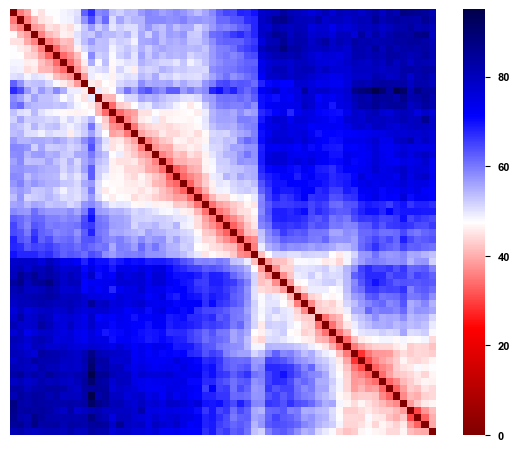

In [478]:
ll = slc1.loops_from_single_chr(chr_id, snapfish2.TwoSampleT)

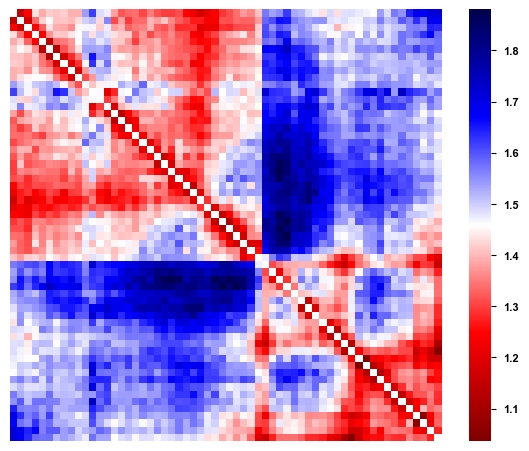

In [479]:
ll = slc1.loops_from_single_chr(chr_id, snapfish2.AxisWiseF)